In [1]:
import numpy as np
import pandas as pd
from jetbrains_issues_dataset.idea.idea_data_set import idea_2018_10_15_to_idea_2020_10_15
from jetbrains_issues_dataset.idea.issue_created_snapshot_strategy import IssueCreatedSnapshotStrategy
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import top_k_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn_helper import fixed_top_k_accuracy_score
import joblib

from two_steps_model.preprocessing.idea.idea_issues_helper import process_issues_attributes, merge_equal_subsystems

In [2]:
issues = idea_2018_10_15_to_idea_2020_10_15(IssueCreatedSnapshotStrategy())
issues = list(issues.values())
issues_with_subsystem = list(filter(lambda x: 'subsystem' in x and x['subsystem'] not in [None, 'Unknown', 'No Subsystem', 'Am uncertain I'], issues))

for issue in issues_with_subsystem:
    process_issues_attributes(issue)
df = pd.DataFrame(issues_with_subsystem)

In [3]:
df

,id,id_readable,comments,first_assignee,last_assignee,state,description,idReadable,summary,commentsCount,...,subsystem,reporter,created at,summary tokenized,description tokenized,all words,text tokenized,stack traces,fixed_at,fixed_by
0,25-2141146,IDEA-200514,{},rvishnyakov,rvishnyakov,Submitted,When a source file has been rearranged using C...,IDEA-200514,Arrange test methods by corresponding tested m...,0,...,Editor. Formatter,roland.illig,2018-10-14 23:03:07,"[arrange, test, method, correspond, test, method]","[source, file, rearrange, use, ctrl, alt, shif...","[arrange, test, method, correspond, test, meth...",arrange test method correspond test method sou...,,NaT,NaN
1,25-2141147,IDEA-200515,{},NaN,NaN,Submitted,I have a very large project with many thousand...,IDEA-200515,Add Fork-by-package unit test mode,2,...,Java. Tests. JUnit,leeh49,2018-10-14 23:03:11,"[add, fork, package, unit, test, mode]","[large, project, many, thousand, test, one, ke...","[add, fork, package, unit, test, mode, large, ...",add fork package unit test mode large project ...,,NaT,NaN
2,25-2141159,IDEA-200516,{},Kirill.Likhodedov,AMPivovarov,Submitted,The scenario is i have a multiline change that...,IDEA-200516,Highlight split changes in Commit Diff window ...,9,...,Version Control. Git,dxclancy,2018-10-14 23:59:43,"[highlight, split, change, commit, diff, windo...","[scenario, multiline, change, wish, move, port...","[highlight, split, change, commit, diff, windo...",highlight split change commit diff window allo...,,NaT,NaN
3,25-2141184,IDEA-200521,{},sdv,julia,Submitted,Version: RD-182.4231.496\nTimezone: Australia/...,IDEA-200521,Can't Go To (Ctrl+F) Tag Twice,5,...,Version Control. Log,thepademelon,2018-10-15 01:39:30,"[go, ctrl, f, tag, twice]","[version, rd, timezone, australia/sydney, eval...","[go, ctrl, f, tag, twice, version, rd, timezon...",go ctrl f tag twice version rd timezone austra...,,NaT,NaN
4,25-2141193,IDEA-200517,{},Kirill.Likhodedov,AMPivovarov,Submitted,when comparing two branches I'm able to merge ...,IDEA-200517,merge completely added/deleted files during br...,2,...,Version Control. Git,syncro,2018-10-15 03:19:59,"[merge, completely, added/deleted, file, branc...","[compare, two, branch, able, merge, change, fi...","[merge, completely, added/deleted, file, branc...",merge completely added/deleted file branch com...,,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31265,25-3007633,IDEA-252944,{},NaN,NaN,Open,![](image.png),IDEA-252944,Completion doesn't work for mappedBy value,0,...,JavaX. JPA,serge,2020-10-15 04:09:06,"[completion, work, map, value]","[image, png]","[completion, work, map, value, image, png]",completion work map value image png,,NaT,NaN
31266,25-3007771,IDEA-252951,{},NaN,NaN,Open,Steps:\nInstall the Chinese Language Pack EAP ...,IDEA-252951,Overlap content in plugin's right copy icon wh...,0,...,Localization,lejia.chen,2020-10-15 08:08:30,"[overlap, content, plugin, right, copy, icon, ...","[step, install, chinese, language, pack, eap, ...","[overlap, content, plugin, right, copy, icon, ...",overlap content plugin right copy icon use lan...,,NaT,NaN
31267,25-3007774,IDEA-252952,{},NaN,NaN,Submitted,When merging some change that has a lot of con...,IDEA-252952,Show conflict resolution progress,0,...,Editor. Diff and Merge,guno,2020-10-15 08:14:54,"[show, conflict, resolution, progress]","[merge, change, lot, conflict, file, hard, kee...","[show, conflict, resolution, progress, merge, ...",show conflict resolution progress merge change...,,NaT,NaN
31268,25-3007807,IDEA-252953,{},NaN,NaN,Open,```\npublic class Sample {\n\n public int f...,IDEA-252953,Extract method fails due to local class even f...,0,...,Java. Extract Method,Alexandr.Suhinin,2020-10-15 08:37:46,"[extract, method, fail, due, local, class, eve...","[public, class, sample, public, int, field, la...","[extract, method, fail, due, local, class, eve...",extract method fail due local class even nor

In [4]:
merge_equal_subsystems(df)

In [5]:
counts = df[['subsystem', 'id']].groupby('subsystem').count()
important_subsystems = counts['id'] > 20

In [6]:
subsystems = df['subsystem'].drop_duplicates().reset_index(drop=True)
subsystems

0               Editor. Formatter
1                            Java
2                 Version Control
3                  User Interface
4                  Infrastructure
                  ...            
192                          jcef
193           Unit Tests Coverage
194    Structure, Hierarchy Views
195                  Unity Plugin
196                           CSS
Name: subsystem, Length: 197, dtype: object

In [7]:
final_df = df[['text tokenized', 'subsystem', 'reporter', 'fixed_by']]

In [8]:
train, test = train_test_split(final_df, random_state=1)
train_assignee = train[train['fixed_by'].notnull()]
test_assignee = test[test['fixed_by'].notnull()]

In [9]:
y_train = train['subsystem']
X_train = train['text tokenized']

pipeline_classifier = Pipeline([
    ('feature', FeatureUnion([
        ('text', Pipeline([
            ('tfidf', TfidfVectorizer(ngram_range=(1, 3), max_df=0.8))
        ])),
    ])),
    ('clf', CalibratedClassifierCV(LinearSVC(C=0.9)))
])
pipeline_classifier.fit(X_train, y_train)

print("Done")

/Users/user/.datalore/anaconda/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Done


In [10]:
counts = df[['subsystem', 'id']].groupby('subsystem').count().sort_values(by=['id'], ascending=False).reset_index()
big_subsystems = counts[counts['id'] > 40]
big_subsystems_names = big_subsystems['subsystem'].tolist()
big_subsystems

,subsystem,id
0,User Interface,6022
1,Java,4385
2,Version Control,3259
3,Build,2568
4,Frameworks,1526
5,Editor,1385
6,Core. IDE Settings,811
7,Code Analysis,793
8,JavaX,693
9,Core. Plugin Management,686


In [11]:
predefined_subsystems = {'Core. Quick Documentation': 'batrdmi', 'Editor. Formatter': 'rvishnyakov', 'Editor. Diff and Merge': 'AMPivovarov', 'Lang. Shell Script': 'Mikhail.Mazurkevich'}

In [12]:
big_subsystems_names

['User Interface',
 'Java',
 'Version Control',
 'Build',
 'Frameworks',
 'Editor',
 'Core. IDE Settings',
 'Code Analysis',
 'JavaX',
 'Core. Plugin Management',
 'Tools. Docker',
 'Core. Run. Configurations',
 'Tools. Terminal',
 'Groovy',
 'Localization',
 'Tools. Kubernetes',
 'Core. Project Settings',
 'Editor. Formatter',
 'Core. Installation',
 'Core. Navigation and Search',
 'Plugin Development (DevKit)',
 'Core. Indexing',
 'Editor. Diff and Merge',
 'Android',
 'Core',
 'Lang. Markdown',
 'Core. Debugger',
 'Core. Platform API',
 'Tools. HTTP Client',
 'Editor. Code Completion',
 'Core. File System',
 'Core. Quick Documentation',
 'Grazie',
 'Core. Task Management',
 'Lang. Shell Script',
 'Core. Profiler',
 'Lang. XML',
 'Core. SSH',
 'Editor. Color Schemes',
 'Core. Refactorings',
 'Editor. Intention Actions',
 'Core. Licensing',
 'IDE',
 'Lang. YAML',
 'Editor. Error Highlighting',
 'Core. Diagrams',
 'Lang. Thymeleaf',
 'Markdown',
 'Core. Run. Targets',
 'Infrastructure'

In [18]:
rows = []
for subsystem in big_subsystems_names:
    if subsystem in predefined_subsystems.keys():
        continue
    subsystem_df_train = train_assignee[train_assignee['subsystem'] == subsystem]
    subsystem_df_test = test_assignee[test_assignee['subsystem'] == subsystem]

    filtered_train = subsystem_df_train.groupby('fixed_by').filter(lambda x: len(x) > max(6, int(len(subsystem_df_train) * 0.06)))
    y_train = filtered_train['fixed_by']
    X_train = filtered_train[['text tokenized', 'reporter']]

    if len(filtered_train['fixed_by'].unique()) == 0:
        print('Subsystem {}. Random developers'.format(subsystem))
        continue

    if len(filtered_train['fixed_by'].unique()) == 1:
        developers_issue_count = len(filtered_train['fixed_by'])
        rate = developers_issue_count / len(subsystem_df_train)
        row = [subsystem, rate, rate, rate]
        rows.append(row)
        print("Subsystem {}: one developer. His rate: {}".format(subsystem, rate))
        continue

    classifier = CalibratedClassifierCV(LinearSVC(C=0.9))
    pipeline_classifier = Pipeline(steps=[
        ('feature', FeatureUnion([
            ("selector", ColumnTransformer([
                ("selector", OneHotEncoder(handle_unknown='ignore'), ['reporter'])
            ])),
            ('text', Pipeline([
                ("selector", ColumnTransformer([
                    ("tfidf", TfidfVectorizer(ngram_range=(1, 3), max_df=0.8), 'text tokenized')
                ]))
            ])),
        ])),
        ('clf', classifier)
    ])
    pipeline_classifier.fit(X_train, y_train)
    filename = 'model/assignee_for_{}_classifier.pkl'.format(subsystem)
    joblib.dump(pipeline_classifier, filename, compress=9)

    cls = joblib.load(filename)

    unique_fixed_by = y_train.drop_duplicates().tolist()
    filtered_test = subsystem_df_test[subsystem_df_test['fixed_by'].isin(unique_fixed_by)]
    X_test = filtered_test[['text tokenized', 'reporter']]
    if len(filtered_test['fixed_by']) == 0:
        print("2. Can't evaluate {}, too few examples".format(subsystem))
        continue
    probas = pipeline_classifier.predict_proba(X_test)

    y_test = filtered_test['fixed_by']
    row = [subsystem]
    for k in [1, 3, 5]:
        top_k_rate = fixed_top_k_accuracy_score(y_test, probas, unique_fixed_by, k=k)
        right_answers = top_k_rate * filtered_test.shape[0]
        real_top_k_rate = right_answers / subsystem_df_test.shape[0]
        row.append(real_top_k_rate)
        print("{} - top {} score: {}".format(subsystem, k, real_top_k_rate))
    rows.append(row)

result = pd.DataFrame(rows, columns=["subsystem", '1', '3', '5'])
result

User Interface - top 1 score: 0.20295202952029523
User Interface - top 3 score: 0.3173431734317343
User Interface - top 5 score: 0.33210332103321033
User Interface - top 10 score: 0.33210332103321033
Java - top 1 score: 0.4665071770334928
Java - top 3 score: 0.645933014354067
Java - top 5 score: 0.65311004784689
Java - top 10 score: 0.65311004784689
Version Control - top 1 score: 0.45989304812834225
Version Control - top 3 score: 0.6631016042780749
Version Control - top 5 score: 0.7058823529411765
Version Control - top 10 score: 0.732620320855615
Build - top 1 score: 0.46616541353383456
Build - top 3 score: 0.6917293233082706
Build - top 5 score: 0.7293233082706767
Build - top 10 score: 0.7293233082706767
Frameworks - top 1 score: 0.5882352941176471
Frameworks - top 3 score: 0.7908496732026143
Frameworks - top 5 score: 0.8627450980392157
Frameworks - top 10 score: 0.869281045751634
Editor - top 1 score: 0.6265060240963856
Editor - top 3 score: 0.6506024096385542
Editor - top 5 score: 0

,subsystem,1,3,5,10
0,User Interface,0.202952,0.317343,0.332103,0.332103
1,Java,0.466507,0.645933,0.653110,0.653110
2,Version Control,0.459893,0.663102,0.705882,0.732620
3,Build,0.466165,0.691729,0.729323,0.729323
4,Frameworks,0.588235,0.790850,0.862745,0.869281
5,Editor,0.626506,0.650602,0.650602,0.650602
6,Core. IDE Settings,0.212766,0.382979,0.382979,0.382979
7,Code Analysis,0.466667,0.586667,0.640000,0.640000
8,JavaX,0.528302,0.773585,0.792453,0.792453
9,Core. Plugin Management,0.140845,0.633803,0.633803,0.633803


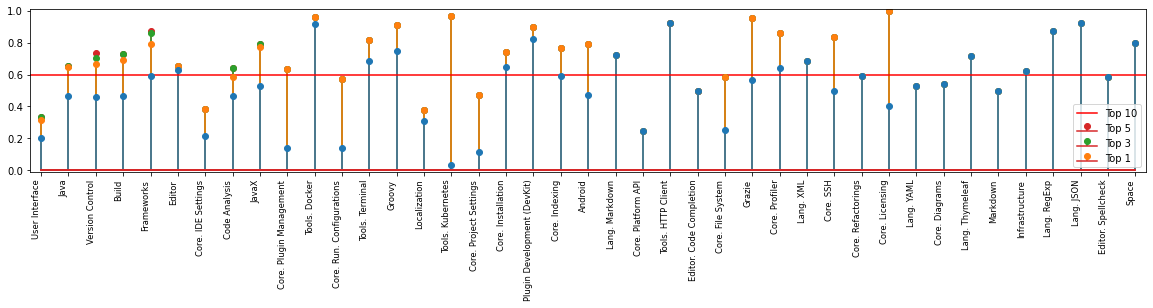

In [19]:
fig = plt.figure(figsize=(20,3))
fig.gca().margins(.01)
plt.xticks(rotation=90, ha='right', fontsize='small')
plt.stem(result['subsystem'], result['5'], use_line_collection=True, linefmt="C2-", markerfmt="C2o")
plt.stem(result['subsystem'], result['3'], use_line_collection=True, linefmt="C1-", markerfmt="C1o")
plt.stem(result['subsystem'], result['1'], use_line_collection=True)
plt.legend(['Top 5', 'Top 3', 'Top 1'])

In [ ]:
issues_without_subsystem = list(filter(lambda x: 'subsystem' not in x or x['subsystem'] in [None, 'Unknown', 'No Subsystem', 'Am uncertain I'], issues))

In [ ]:
filename = 'model/subsystem.pkl'
joblib.dump(pipeline_classifier, filename, compress=9)

In [ ]:
y_test = test['subsystem']
X_test = test['text tokenized']

In [ ]:
pipeline_classifier.score(X_test, y_test)

In [35]:
test.shape

(7818, 2)

In [36]:
unique_trained_subsystems = y_train.drop_duplicates().tolist()

In [37]:
filtered_test = test[test['subsystem'].isin(unique_trained_subsystems)]
filtered_test.shape

(7652, 2)

In [38]:
y_test = filtered_test['subsystem']
X_test = filtered_test['text tokenized']

In [39]:
probas = pipeline_classifier.predict_proba(X_test)

In [41]:
top_k_rate = top_k_accuracy_score(y_test, probas, k=3)
right_answers = top_k_rate * filtered_test.shape[0]
right_answers / test.shape[0]

0.8818112049117421

In [43]:
def score_with_threshold(classifier, y_true, probas, threshold):
    classes = classifier.classes_
    sure_indices = np.max(probas, axis=1) > threshold
    sure_y_test = y_true[sure_indices].to_numpy()
    sure_probas = probas[sure_indices]
    sure_y_test_unique = np.unique(sure_y_test)
    probas_indices_filtered = np.where(np.isin(classes, sure_y_test_unique))[0].tolist()

    probas_filtered = np.take(sure_probas, probas_indices_filtered, axis=1)

    return top_k_accuracy_score(sure_y_test, probas_filtered, k=3), len(sure_y_test) / len(y_true)


threshold = 0.1
thresholds = []
sure_scores = []
issues_passed_to_threshold = []
while threshold < 1 - 1e-6:
    sure_score, left_samples = score_with_threshold(pipeline_classifier, y_test, probas, threshold)
    thresholds.append(threshold)
    sure_scores.append(sure_score)
    issues_passed_to_threshold.append(left_samples)
    threshold += 0.1

Threshold


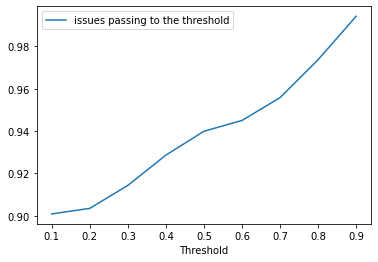

In [46]:
plt.xlabel('Threshold')
plt.plot(thresholds, sure_scores)

plt.legend(['issues passing to the threshold'])
print('Threshold')

Threshold


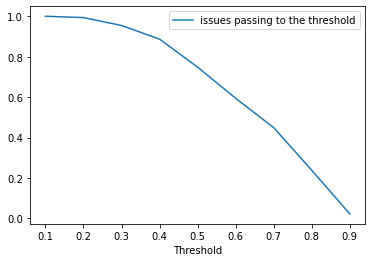

In [47]:
plt.xlabel('Threshold')
plt.plot(thresholds, issues_passed_to_threshold)
plt.legend(['issues passing to the threshold'])
print('Threshold')